# Graph-Based Image Segmentation Using Union-Find (Felzenszwalb–Huttenlocher)

This notebook demonstrates a from-scratch implementation of the FH algorithm using a custom Union-Find (Disjoint Set Union) with path compression and union by rank. It is designed to run both locally and on Google Colab.

- Implements dynamic image loading: upload, sample images, or URL
- Uses only NumPy, Matplotlib, and selected scikit-image utilities (I/O, color, gaussian)
- No prebuilt segmentation/clustering libraries
- Visualizes segmentation, explores parameters (k, min_size, sigma), counts segments, and shows individual segments




## 1) Environment setup 
If running on Google Colab, the following cell will clone the repo into `/content` and adjust `sys.path` so imports from `src/` work. Locally, it will just set up the path based on this notebook's directory.


In [1]:
import os, sys, subprocess
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

IN_COLAB = 'google.colab' in sys.modules

def run(cmd):
    try:
        subprocess.check_call(cmd, shell=True)
    except Exception as e:
        print('Command failed:', cmd, e)

if IN_COLAB:
    run('pip -q install numpy matplotlib scikit-image requests pillow')
    REPO_DIR = Path('/content/img-segmentation')
    if not REPO_DIR.exists():
        run('git clone -q https://github.com/your-org-or-user/img-segmentation.git /content/img-segmentation')
    sys.path.append(str(REPO_DIR / 'src'))
else:
    NB_DIR = Path.cwd()
    SRC_DIR = (NB_DIR.parent / 'src').resolve()
    if str(SRC_DIR) not in sys.path:
        sys.path.append(str(SRC_DIR))

print('IN_COLAB:', IN_COLAB)



IN_COLAB: False


## 2) Imports and utility bindings
We will import our custom modules from `src/` and basic libraries used for I/O and visualization.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Optional

# Import project modules
from union_find import UnionFind # type: ignore
from fh_segmentation import felzenszwalb_huttenlocher, analyze_segments
from image_utils import (
    load_sample_image, load_image_from_file, load_image_from_url,
    preprocess_image, get_image_info, create_sample_images
)
from visualization import (
    create_segmentation_comparison, create_segment_gallery,
    create_segment_size_histogram, create_parameter_comparison_plot
)

%matplotlib inline


## 3) Image loading: upload, sample, or URL
Use one of the following options:
- Upload (Colab: file picker; Local: provide a file path)
- Sample image from `skimage.data`
- URL image (HTTP/HTTPS)

The helper function below makes this dynamic via a `source_type` parameter.


In [3]:
try:
    from google.colab import files  # type: ignore
    IN_COLAB = True
except Exception:
    IN_COLAB = False


def load_image(source_type: str,
                       sample_name: str = 'coffee',
                       local_path: Optional[str] = None,
                       url: Optional[str] = None,
                       max_size: int = 512):
    """
    Load image based on source type: 'upload' | 'sample' | 'url' | 'path'.
    - upload: prompts file picker in Colab; in local, use 'path'.
    - sample: loads from skimage.data via image_utils
    - url: downloads from the internet
    - path: loads from a local path
    """
    if source_type == 'sample':
        img = load_sample_image(sample_name)
    elif source_type == 'url':
        if not url:
            raise ValueError("URL not provided for source_type='url'")
        img = load_image_from_url(url)
    elif source_type == 'path':
        if not local_path:
            raise ValueError("local_path not provided for source_type='path'")
        img = load_image_from_file(local_path)
    elif source_type == 'upload':
        if not IN_COLAB:
            raise RuntimeError("Upload is supported only in Colab; use source_type='path' locally.")
        up = files.upload()
        if not up:
            raise RuntimeError("No file uploaded.")
        fname = next(iter(up.keys()))
        img = load_image_from_file(fname)
    else:
        raise ValueError("Invalid source_type. Choose from 'sample', 'url', 'path', 'upload'.")

    img = preprocess_image(img, max_size=max_size, convert_to_rgb=True)
    info = get_image_info(img)
    print('Loaded image:', info)
    return img


## 4) Quick check: Union-Find behavior
We create a small Union-Find, perform unions/finds, and verify path compression and union by rank conceptually.


In [4]:
# Small Union-Find demo
uf_demo = UnionFind(10)
uf_demo.union(1, 2)
uf_demo.union(2, 3)
uf_demo.union(5, 6)
print('Find(3):', uf_demo.find(3))
print('Find(6):', uf_demo.find(6))
print('Num sets before union(3,6):', uf_demo.num_sets)
uf_demo.union(3, 6)
print('Num sets after union(3,6):', uf_demo.num_sets)


Find(3): 1
Find(6): 5
Num sets before union(3,6): 7
Num sets after union(3,6): 6


In [5]:
print('Find(3):', uf_demo.find(3))
print('Find(6):', uf_demo.find(6))

Find(3): 1
Find(6): 1


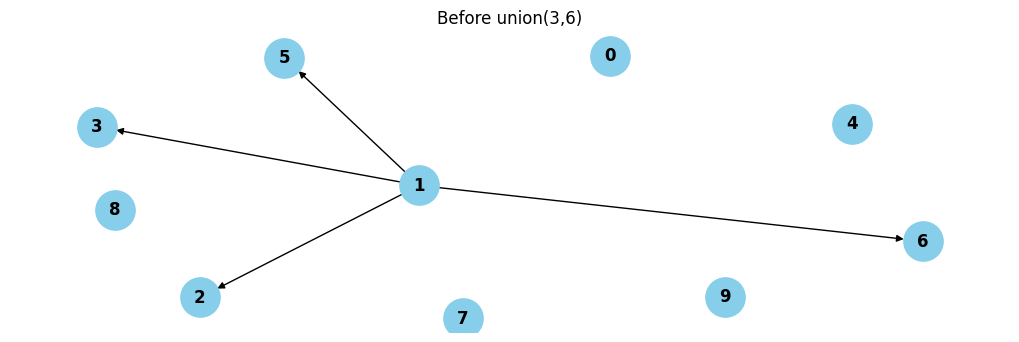

Find(3): 1
Find(0): 0
Num subgraphs before union(3,0): 6
Num subgraphs after union(3,0): 5


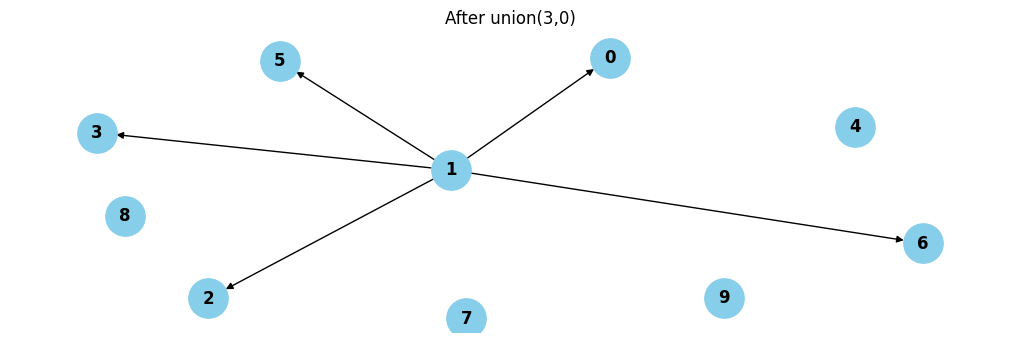

In [6]:
import networkx as nx
#  Helper function to draw uf sets
def draw_union_find(uf, title):
    G = nx.DiGraph()
    for i in range(len(uf.parent)):
        G.add_node(i)
        if uf.parent[i] != i:
            G.add_edge(uf.parent[i], i)
    
    pos = nx.spring_layout(G, seed=42)  # Consistent layout
    plt.figure(figsize=(10, 3))
    nx.draw(G, pos, with_labels=True, node_size=800,
            node_color="skyblue", font_weight="bold", arrows=True)
    plt.title(title)
    plt.show()

#Visualization before merging (3,0)
draw_union_find(uf_demo, "Before union(3,6)")

print('Find(3):', uf_demo.find(3))
print('Find(0):', uf_demo.find(0))
print('Num subgraphs before union(3,0):', uf_demo.num_sets)

# Perform the union and visualize again
uf_demo.union(3, 0)
print('Num subgraphs after union(3,0):', uf_demo.num_sets)
draw_union_find(uf_demo, "After union(3,0)")

## 5) Load an image
Pick one approach below: set `source_type` to `'sample'`, `'url'`, `'path'`, or `'upload'` (upload works only in Colab).


Loaded image: {'height': 341, 'width': 512, 'channels': 3, 'is_color': True, 'dtype': 'uint8', 'shape': (341, 512, 3), 'total_pixels': 174592}


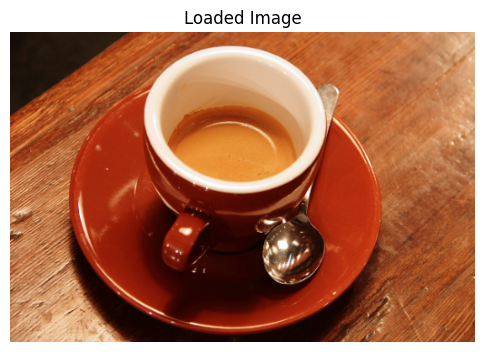

In [7]:
# Configure your source here
source_type = 'sample'  # 'sample' | 'url' | 'path' | 'upload'
sample_name = 'coffee'  # e.g., 'coffee', 'astronaut', 'camera'
local_path = None       # e.g., r'img-segmentation\assets\demo-shot.png'
url = None              # e.g., 'https://upload.wikimedia.org/...'

image = load_image(source_type, sample_name, local_path, url, max_size=512)

plt.figure(figsize=(6,6))
if image.ndim == 2:
    plt.imshow(image, cmap='gray')
else:
    plt.imshow(image)
plt.title('Loaded Image')
plt.axis('off')
plt.show()


## 6) Run FH segmentation (single setting)
We segment once to validate the pipeline. Parameters:
- `k`: merge threshold constant
- `min_size`: minimum allowed component size
- `sigma`: Gaussian smoothing stddev (0 disables smoothing)


Segments: 15 | k=100, min_size=50, sigma=0.8


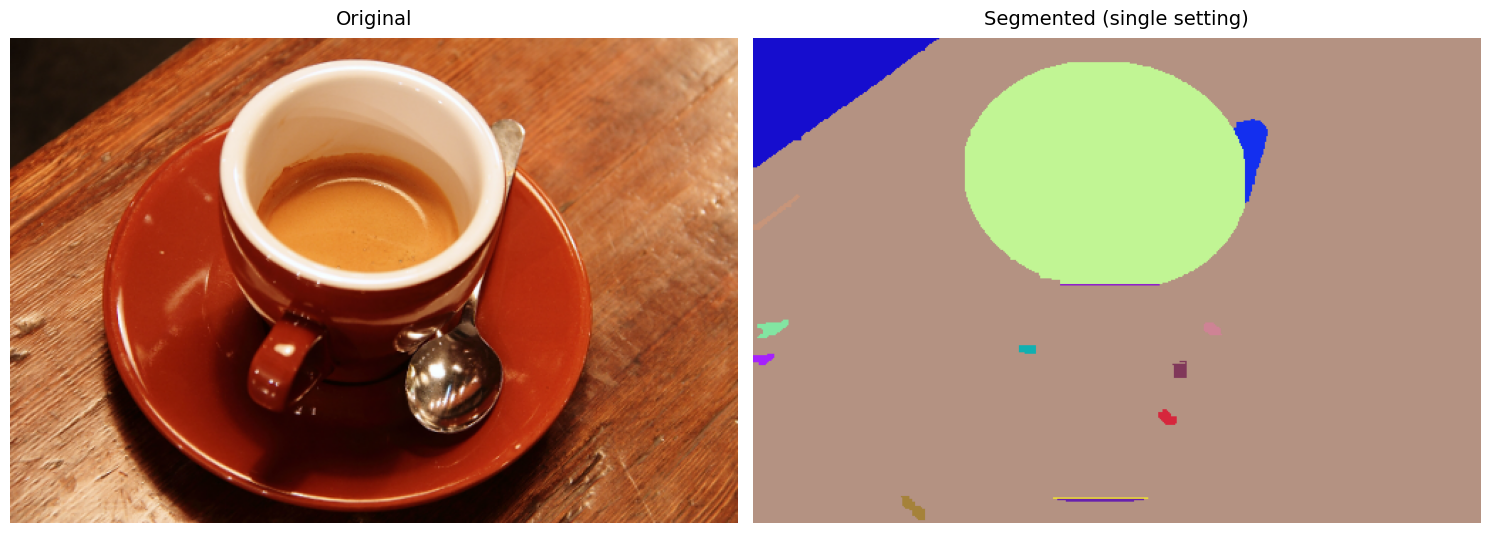

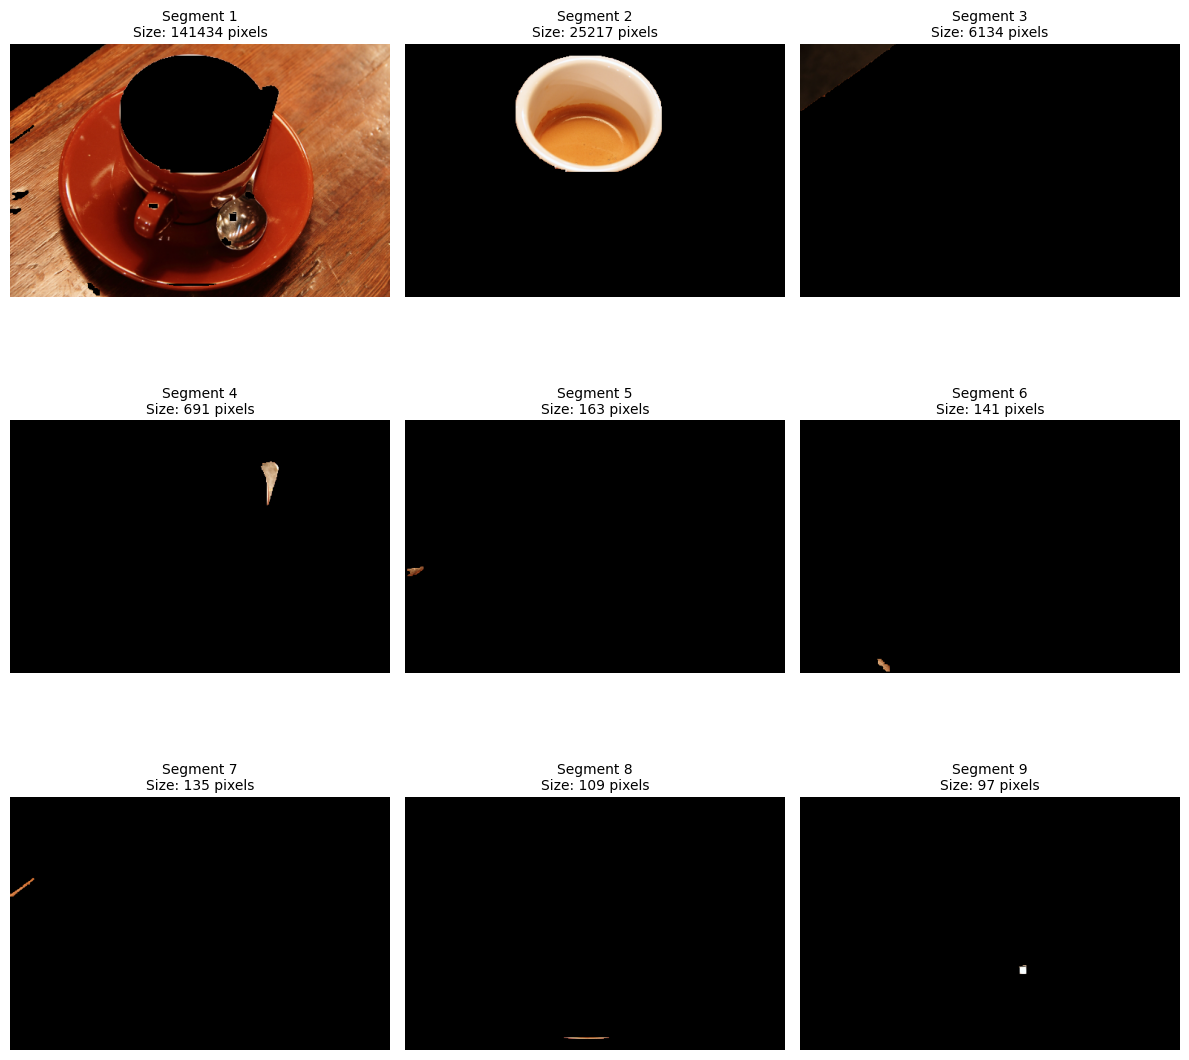

In [8]:
k = 100
min_size = 50
sigma = 0.8

segmented_image, num_segments, uf = felzenszwalb_huttenlocher(image, k=k, min_size=min_size, sigma=sigma)
print(f"Segments: {num_segments} | k={k}, min_size={min_size}, sigma={sigma}")

_ = create_segmentation_comparison(image, segmented_image,
                                 titles=["Original", "Segmented (single setting)"])
plt.show()

analysis = analyze_segments(image, uf, top_n=9)

_ = create_segment_gallery(image, analysis['largest_segments'], analysis['segment_info'], grid_size=(3,3))
plt.show()


## 7) Parameter experiments (k, min_size, sigma)
We vary one parameter at a time while keeping others fixed, compare number of segments and mean sizes, and visualize representative outputs side-by-side.


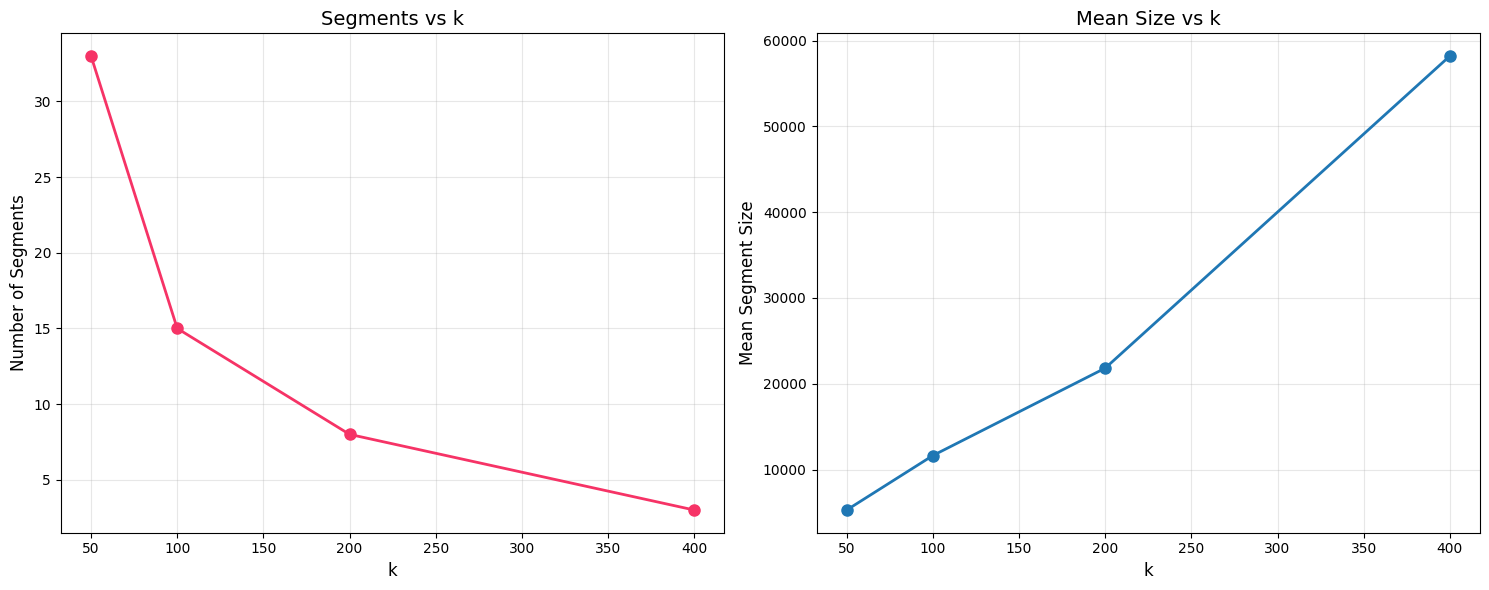

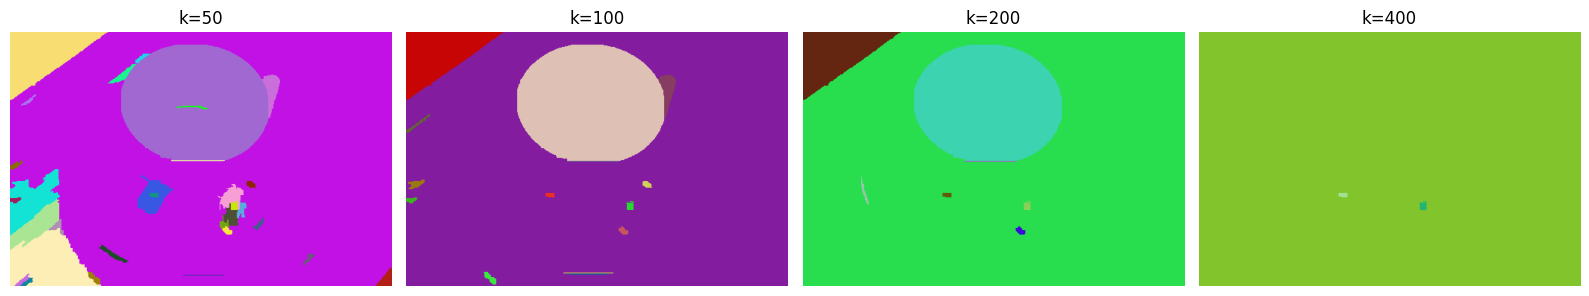

In [9]:
def run_param_sweep(image, base_k=200, base_min_size=50, base_sigma=0.8,
                    vary='k', values=(50, 100, 200, 400)):
    reports = []
    outputs = []
    for val in values:
        k = base_k
        min_size = base_min_size
        sigma = base_sigma
        if vary == 'k':
            k = val
        elif vary == 'min_size':
            min_size = val
        elif vary == 'sigma':
            sigma = val

        seg, nseg, uf_obj = felzenszwalb_huttenlocher(image, k=k, min_size=min_size, sigma=sigma)
        analysis_res = analyze_segments(image, uf_obj, top_n=9)
        params = {'k': k, 'min_size': min_size, 'sigma': sigma}
        from visualization import generate_segmentation_report
        report = generate_segmentation_report(analysis_res, params)
        reports.append(report)
        outputs.append((val, seg))
    return reports, outputs

# Example sweeps (pick one at a time to run)
reports_k, outputs_k = run_param_sweep(image, vary='k', values=(50, 100, 200, 400))
fig = create_parameter_comparison_plot(reports_k, 'k')
plt.show()

# Show a few segmented outputs for k sweep
fig, axes = plt.subplots(1, min(4, len(outputs_k)), figsize=(16,4))
for ax, (val, seg) in zip(axes, outputs_k[:4]):
    if seg.ndim == 2:
        ax.imshow(seg, cmap='gray')
    else:
        ax.imshow(seg)
    ax.set_title(f'k={val}')
    ax.axis('off')
plt.tight_layout()
plt.show()


## 8) FH + Union-Find
- Build a graph over pixels with edges to neighbors weighted by squared color/gray differences.
- Sort edges by weight and iterate from small to large.
- Maintain components with Union-Find; merge when edge weight is below adaptive threshold.
- Merge tiny components in a final pass (`min_size`).
- Assign random colors per component to visualize segments.


## 9) Challenges faced and how they were handled
- uint8 overflow when squaring differences:  compute differences as float by casting.
- Grayscale vs. color mismatch: we check image dimensionality (`image.ndim`) everywhere and handle 2D grayscale distinct from 3D color, avoiding unpacking errors and incorrect channel assumptions.


## 12) Summary 
- Union-Find with path compression and union by rank enables efficient component maintenance across dense pixel graphs.
- FH segmentation preserves boundaries by comparing edge weights to adaptive thresholds rather than fixed ones.
- Parameter control: increasing `k` coarsens segments; `min_size` removes small fragments; `sigma` reduces noise but can blur edges if too high.
- Robust handling of datatypes and image modes (grayscale vs. RGB) is crucial for correct and stable implementations.

In General, 
- Relationship Overview

| Parameter    | What it Controls                                               | Effect on Number of Segments                                                                                                         |
| ------------ | -------------------------------------------------------------- | ------------------------------------------------------------------------------------------------------------------------------------ |
| **k**        | Threshold for merging — controls how easily regions are joined | ↑ **k** → fewer, larger segments (more merging) <br>↓ **k** → more, smaller segments (less merging)                                  |
| **min_size** | Minimum allowable component size                               | ↑ **min_size** → fewer, larger segments (forces small regions to merge) <br>↓ **min_size** → more, smaller segments remain           |
| **sigma**    | Gaussian smoothing (preprocessing)                             | ↑ **sigma** → smoother image → fewer, larger segments <br>↓ **sigma** → noisier image, more fine detail → more segments |
